In [1]:
%pip install numpy==1.26.4
%pip install pandas==2.1.4
%pip install seaborn==0.13.2


[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Efficiency
As part of the analysis, the efficiency of the wallet app is evaluated in two variants: with and without the pre-consent mechanism. 
The analysis focuses on the impact of the pre-consent mechanism on the duration of the consent process.

In [2]:
import os
import glob
import pandas as pd
import seaborn as sns

from IPython.display import display, HTML, Markdown

sns.set_theme()

## Data Source
Load all timestamp files of the participants and store them in a data frame.

In [3]:
# Directory containing the CSV files
timestamps_dir = 'data/timestamps'

# Get all files matching the pattern
file_pattern = os.path.join(timestamps_dir, "timestamps_*.csv")
file_list = glob.glob(file_pattern)

# Read all files
df_list = []

for file in file_list:
    # Extract the <ID> from the file name
    file_name = os.path.basename(file)
    file_id = file_name.split("_")[1].split(".")[0]

    # Load the file into a DataFrame
    df = pd.read_csv(file)

    # Add the <ID> to the DataFrame
    df['ID'] = file_id

    # Append the DataFrame to the list
    df_list.append(df)

# Concatenate all DataFrames
df = pd.concat(df_list, ignore_index=True)

# Convert unit of column 'Dauer' to seconds (from milliseconds)
df['Duration'] = df['Duration'] / 1000

# Create a new column 'Pre-Consent' with custom labels mapped from 'Pre-Consent Enabled'
# This makes the subplot titles and legend labels clearer and more user-friendly
df['Pre-Consent'] = df['Pre-Consent Enabled'].map({True: 'With', False: 'Without'})

# Display the first few rows
df.head()

,Task,Day,Verifier,Starttime,Endtime,Duration,Pre-Consent Enabled,Pre-Consent Configured,ID,Pre-Consent
0,1,1,LMU Reader,1732978822980,1732978834109,11.129,False,False,22,Without
1,2,1,Studierendenwerk Reader,1732978844549,1732978854033,9.484,False,False,22,Without
2,3,1,SaveSeat GmbH Reader,1732978922426,1732978940950,18.524,False,False,22,Without
3,4,2,Studierendenwerk Reader,1732978958040,1732978964958,6.918,False,False,22,Without
4,5,2,SaveSeat GmbH Reader,1732978975773,1732978980479,4.706,False,False,22,Without


## Average Duration per Task/Transaction
First, we examine the averaged duration per task using a heatmap in a 5x3 grid format, representing 5 days (Monday to Friday) and 3 tasks/transactions per day. 
The color of each cell indicates the duration, with darker colors denoting longer times taken by participants, on average, to share consent.

<Axes: xlabel='Day', ylabel='Task'>

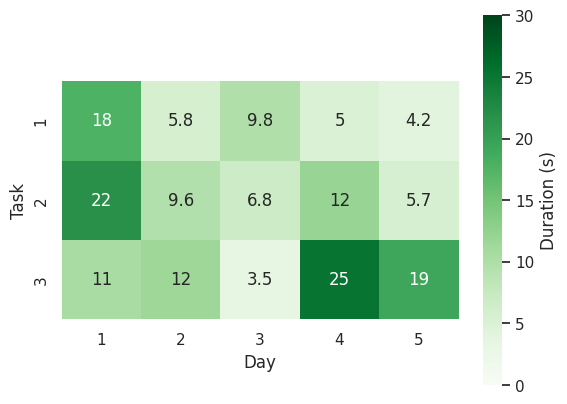

In [4]:
avg_duration_per_task = df.groupby(['Pre-Consent Enabled', 'Day', 'Task'])['Duration'].mean()

# Cont min/max heatmap value to allow for comparison
VMIN = 0
VMAX = 30

###
# Heatmap for variant w/o preconsent
###
pre_consent_disabled = avg_duration_per_task.xs(False, level='Pre-Consent Enabled').reset_index()

# Update task IDs to cycle between 1-3 for each day
pre_consent_disabled['Task'] = (pre_consent_disabled['Task'] - 1) % 3 + 1

# Pivot the data to form a 3x5 (task x day) grid
pre_consent_disabled = pd.pivot(pre_consent_disabled, index='Task', columns='Day', values='Duration')

# Plot heatmap
sns.heatmap(pre_consent_disabled, annot=True, square=True, cmap='Greens', vmin=VMIN, vmax=VMAX, cbar_kws={'label': 'Duration (s)'})

<Axes: xlabel='Day', ylabel='Task'>

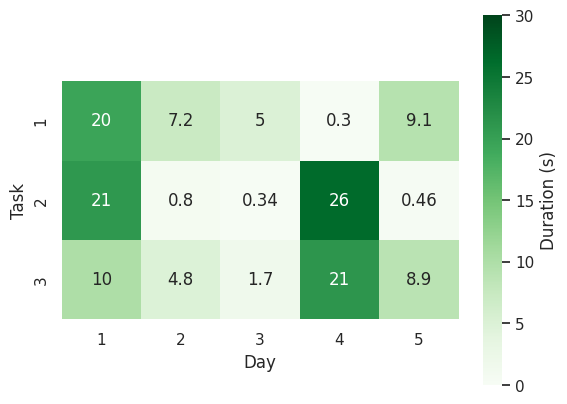

In [5]:
###
# Heatmap for variant w/ heatmap
###
pre_consent_enabled = avg_duration_per_task.xs(True, level='Pre-Consent Enabled').reset_index()

# Update task IDs to cycle between 1-3 for each day
pre_consent_enabled['Task'] = (pre_consent_enabled['Task'] - 1) % 3 + 1

# Pivot the data to form a 3x5 (task x day) grid
pre_consent_enabled = pd.pivot(pre_consent_enabled, index='Task', columns='Day', values='Duration')

# Plot heatmap
sns.heatmap(pre_consent_enabled, annot=True, square=True, cmap='Greens', vmin=VMIN, vmax=VMAX, cbar_kws={'label': 'Duration (s)'})

## Total Duration per Day per Participant
Next, we calculate the total duration per day by summing the durations of all transactions for that day. 
Each day consists of three transactions (also referred to as tasks). 
We aggregate the task durations to compute the total duration per day for each participant. 
This approach provides insights into the overall time required for participants to complete all transactions on a given day.

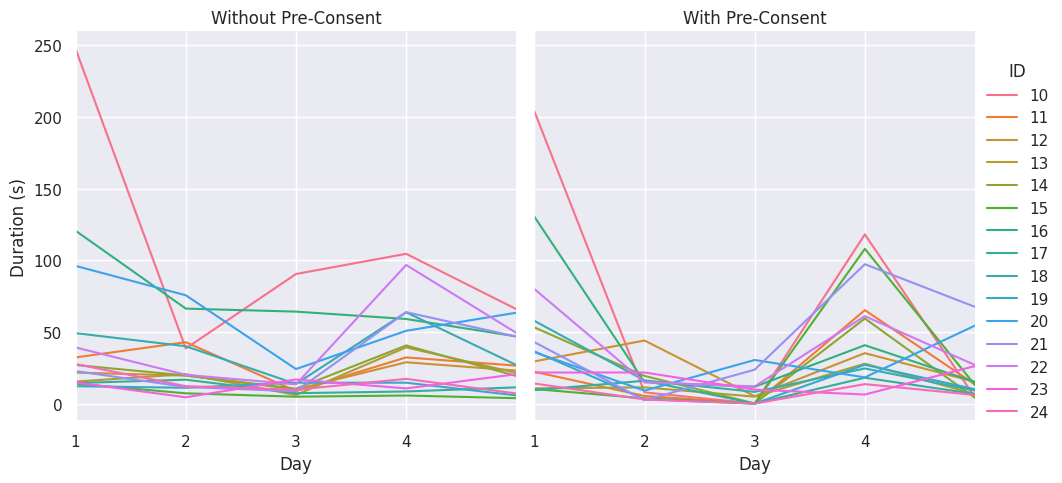

In [6]:
# Group elements by variant, ID and  day
grouped = df.groupby(['Pre-Consent Enabled', 'Pre-Consent', 'ID', 'Day'])

# Calculate the duration per day
duration_per_day = grouped['Duration'].sum()


# Display line graph
ax = sns.relplot(
    data=duration_per_day.reset_index(),
    x='Day',
    y='Duration',
    hue='ID',
    col='Pre-Consent',
    kind='line',
)

# Configure axes
ax.set(
    ylabel='Duration (s)',
    xticks=range(1, 5),
    xlim=(1, 5),
)

ax.set_titles('{col_name} Pre-Consent')

## Average Total Duration per Day
Next, we calculate the average total duration per day across all participants. 
The results are visualized using a series of boxplots, with one boxplot representing each variant (with and without pre-consent) for each day. 

The duration is shorter on the majority of days (2, 3, and 5) for the pre-consent-enabled variant. 
However, deviations occur on day 4, where durations are slightly higher, due to pre-consent updates (see heatmap cells (4,2), (4,3) of second graph), and on day 1, where durations are noticeably higher as participants familiarized themselves with the pre-consent mechanism (see heatmap cells (1,1), (1,2)). 
Additionally, participants had free choice and had to decide for themselves whether to set up a pre-consent during this phase, which contributed to the increased durations on the first day.

### Mean and Standard Deviation for Total Duration by Day

Pre-Consent   With               Without              
              Mean Median     SD    Mean Median     SD
Day                                                   
1            50.49  35.86  53.23   50.21  26.90  62.98
2            12.79  11.29  10.72   27.02  19.56  21.34
3             7.03   4.80   9.37   20.13  10.35  24.19
4            47.99  35.14  35.70   42.35  39.19  30.82
5            18.51  12.81  18.72   29.14  23.00  20.41

[Text(0, 0.5, 'Duration (s)')]

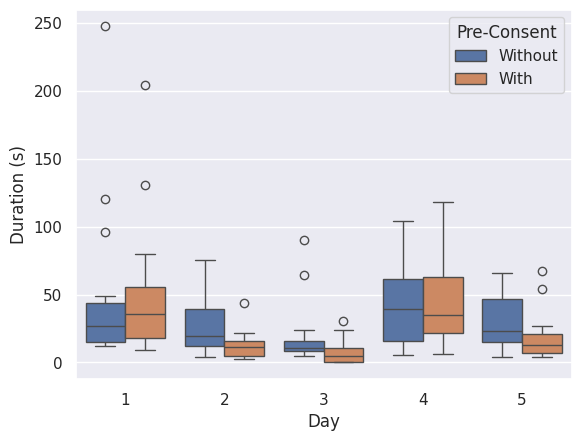

In [7]:
day_duration_df = df.groupby(['Pre-Consent', 'Day', 'ID'])['Duration'].sum()


day_duration_stats = day_duration_df.groupby(['Pre-Consent', 'Day']).agg(['mean', 'std', 'median']).round(2).reset_index()
day_duration_stats.columns = ['Pre-Consent', 'Day', 'Mean', 'SD', 'Median']

# Pivot the table
day_duration_stats = day_duration_stats.pivot(index='Day', columns='Pre-Consent', values=['Mean', 'SD', 'Median'])
day_duration_stats = day_duration_stats.reorder_levels([1, 0], axis=1).sort_index(axis=1, level=0)

# Display the table
display(Markdown("### Mean and Standard Deviation for Total Duration by Day"))
display(day_duration_stats)


ax = sns.boxplot(
    data=duration_per_day.reset_index(),
    x='Day',
    y='Duration',
    hue='Pre-Consent',
    hue_order=['Without', 'With']
)

ax.set(ylabel="Duration (s)")

## Average Total Duration per Variant
Next, the average total duration is calculated for each variant across all days. 
This provides an aggregated perspective on the overall performance differences between the variants, offering insights into the influence of the pre-consent mechanism on transaction durations.

### Mean and Standard Deviation for Duration by Pre-Consent Variant

,Pre-Consent,Mean,SD
0,With,136.799400,79.544983
1,Without,168.848133,140.228044


[Text(0, 0.5, 'Duration (s)')]

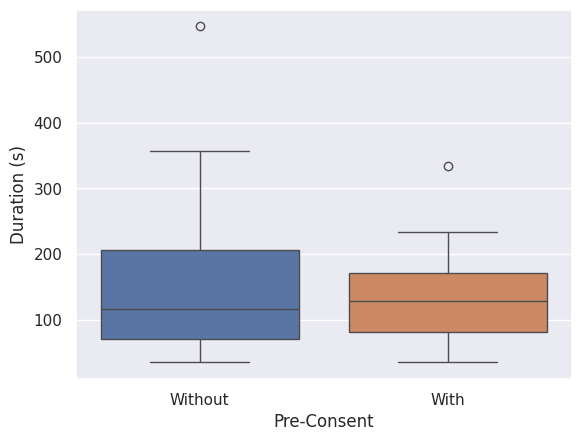

In [8]:
duration_per_variant = duration_per_day.groupby(['Pre-Consent Enabled', 'Pre-Consent', 'ID']).sum()

duration_stats = duration_per_variant.groupby('Pre-Consent').agg(['mean', 'std']).reset_index()
duration_stats.columns = ['Pre-Consent', 'Mean', 'SD']

# Display the table
display(Markdown("### Mean and Standard Deviation for Duration by Pre-Consent Variant"))
display(duration_stats)

ax = sns.boxplot(
    data=duration_per_variant.reset_index(),
    x='Pre-Consent',
    y='Duration',
    hue='Pre-Consent'
)

ax.set(ylabel="Duration (s)")

## Avg. Total Duration per Verifier
Next, we analyze the average total duration for each verifier, broken down by variant (with and without pre-consent). 
This comparison provides insights into how the pre-consent mechanism impacts transaction durations across different verifiers.

The analysis shows that the average total duration is lower with pre-consent for all verifiers except the "LMU reader." 
To understand this exception, we take a closer look at the transactions performed with the LMU reader as well as the Studierendenwerk Reader (for comparison).

### Mean and Standard Deviation for Duration by Verifier

Pre-Consent               With               Without              
                          Mean Median     SD    Mean Median     SD
Verifier                                                          
LMU Reader               15.38   5.37  28.86   10.57   5.24  12.79
MVG Reader                4.45   3.30   5.00    8.30   6.01   7.75
SaveSeat GmbH Reader     11.23   6.13  15.38   16.20   7.70  19.42
Studierendenwerk Reader   4.29   0.00  13.05    9.04   3.75  21.29

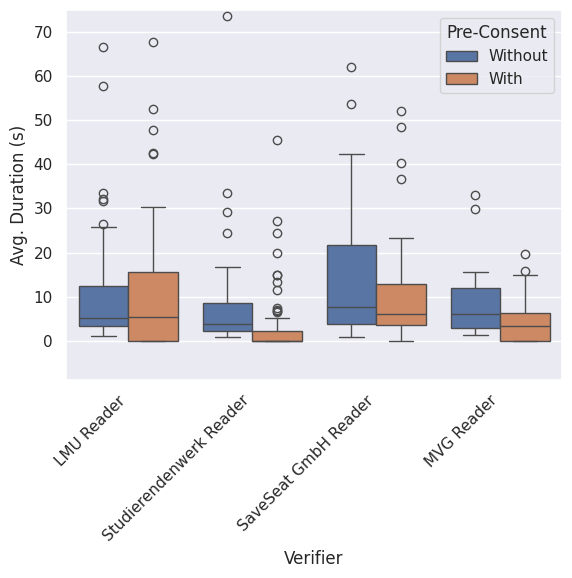

In [9]:
verifier_df = df[['Pre-Consent', 'Verifier', 'Duration']]

verifier_duration_stats = verifier_df.groupby(['Pre-Consent', 'Verifier']).agg(['mean', 'std', 'median']).round(2).reset_index()
verifier_duration_stats.columns = ['Pre-Consent', 'Verifier', 'Mean', 'SD', 'Median']

# Pivot the table
verifier_duration_stats = verifier_duration_stats.pivot(index='Verifier', columns='Pre-Consent', values=['Mean', 'SD', 'Median'])
verifier_duration_stats = verifier_duration_stats.reorder_levels([1, 0], axis=1).sort_index(axis=1, level=0)

# Display the table
display(Markdown("### Mean and Standard Deviation for Duration by Verifier"))
display(verifier_duration_stats)

# Plot the boxplot
ax = sns.boxplot(
    data=verifier_df,
    x='Verifier',
    y='Duration',
    hue='Pre-Consent',
)

ax.set_ylim(top=75)
ax.set(ylabel="Avg. Duration (s)")

# Rotate x-axis labels using ax.set
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

### LMU Reader
We display the average total duration per day (also per task, because its only one task per day) for each variant using a boxplot. 
In total, four transactions were scheduled during the week (Monday, Wednesday, Thursday, and Friday), with at most one transaction per day.

The results show that the duration is increased on day 4 (Thursday) and day 5 (Friday) for the variant with pre-consent. 
This is because participants may have encountered the pre-consent update screen, particularly on Thursday. 
On Thursday, it was also the first time most users interacted with the pre-consent update UI and had to familiarize themselves with the new interface.

,mean,median,std
Day,,,
1,19.359833,9.2580,33.212698
3,5.892033,3.3575,8.290744
4,19.218867,12.6195,23.114199
5,7.429433,2.8720,13.387309


[Text(0, 0.5, 'Duration (s)')]

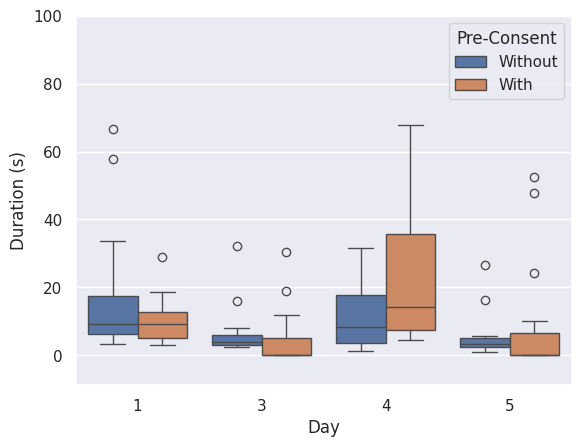

In [10]:
# Filter the DataFrame for the LMU verifier
lmu_verifier_df = df.loc[df['Verifier'] == 'LMU Reader', ['Pre-Consent', 'Verifier', 'Day', 'Duration']]

lmu_verifier_stats = lmu_verifier_df.groupby('Day')['Duration'].agg(['mean', 'median', 'std'])

# Display the table
display(lmu_verifier_stats)



ax = sns.boxplot(
    data=lmu_verifier_df,
    x='Day',
    y='Duration',
    hue='Pre-Consent'
)

ax.set_ylim(top=100)
ax.set(ylabel="Duration (s)")

## Studierendenwerk Reader
The average total duration for each variant is presented using a boxplot. Over the course of the week, five transactions were scheduled in total. For both variants, one transaction was scheduled on Monday, Tuesday, and Friday. However, the schedule differed on Wednesday and Thursday between the two variants.

For the variant without pre-consent, two transactions were scheduled on Wednesday, while no transactions were scheduled on Thursday. In contrast, for the variant with pre-consent, one transaction was scheduled on both Wednesday and Thursday.

The results indicate an increased duration on day 1 (Monday) for the variant with pre-consent. This can be attributed to participants encountering the pre-consent UI for the first time and needing to familiarize themselves with the new interface.

,mean,median,std
Day,,,
1,19.359833,9.2580,33.212698
3,5.892033,3.3575,8.290744
4,19.218867,12.6195,23.114199
5,7.429433,2.8720,13.387309


[Text(0, 0.5, 'Duration (s)')]

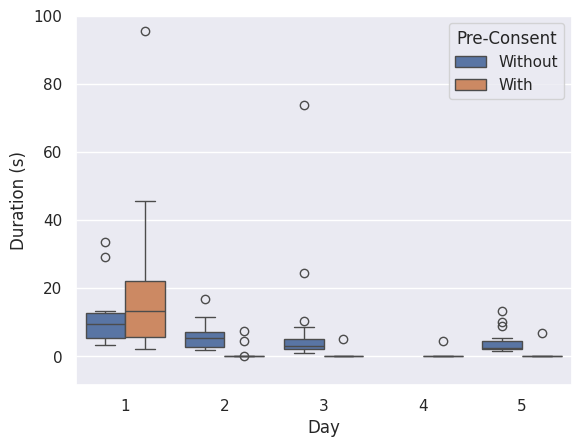

In [12]:
# Filter the DataFrame for the LMU verifier
stwm_verifier_df = df.loc[df['Verifier'] == 'Studierendenwerk Reader', ['Pre-Consent', 'Verifier', 'Day', 'Duration']]

stwm_verifier_stats = lmu_verifier_df.groupby('Day')['Duration'].agg(['mean', 'median', 'std'])

# Display the table
display(lmu_verifier_stats)

ax = sns.boxplot(
    data=stwm_verifier_df,
    x='Day',
    y='Duration',
    hue='Pre-Consent'
)

ax.set_ylim(top=100)
ax.set(ylabel="Duration (s)")